In [19]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating new environment at `~/GitHub/admm-lqr/Project.toml`
  No Changes to `~/GitHub/admm-lqr/Project.toml`
  No Changes to `~/GitHub/admm-lqr/Manifest.toml`


In [20]:
using LinearAlgebra
using PyPlot

In [21]:
#2D Double-integrator dynamics
h = 0.05 #20 Hz
A = [I(2) h*I(2); zeros(2,2) I(2)]
B = [0.5*h*h*I(2); h*I(2)];

In [22]:
#Reference state trajectory to track (origin)
t = 0:h:10
N = length(t)
xref = zeros(4,N)

#Reference input trajectory
uref = zeros(2,N-1);

In [23]:
#Cost Function
# J = Σ 0.5*(x-xref)'*Q*(x-xref) + 0.5*(u-uref)*R*(u-uref) + 0.5*xn'*Qn*xn
Qn = 10.0*I(4)
Q = 10.0*I(4)
R = 0.1*I(2)

q = zeros(4,N)
r = zeros(2,N-1)

function cost(x,u)
    J = 0.0
    for k = 1:(N-1)
        J += 0.5*(x[:,k]-xref[:,k])'*Q*(x[:,k]-xref[:,k]) + 0.5*(u[:,k]-uref[:,k])'*R*(u[:,k]-uref[:,k])
    end
    J += 0.5*(x[:,N]-xref[:,N])'*Qn*(x[:,N]-xref[:,N])
    return J
end

cost (generic function with 1 method)

In [24]:
#ADMM Functions
function riccati!(A,B,Q,q,R,r,P,p,K,m)
    #This is the standard Riccati backward pass with both linear and quadratic terms (like iLQR)
    for k = (N-1):-1:1
        K[:,:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
        m[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + r[:,k])
    
        P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (A-B*K[:,:,k])'*P[:,:,k+1]*(A-B*K[:,:,k])
        p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*(p[:,k+1]-P[:,:,k+1]*B*m[:,k]) + K[:,:,k]'*(R*m[:,k]-r[:,k])
    end
end

function riccati_grad!(A,B,q,R,r,P,p,K,m)
    #This is just the linear/gradient term from the backward pass (no cost-to-go Hessian or K calculations)
    for k = (N-1):-1:1
        m[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + r[:,k])
        p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*(p[:,k+1]-P[:,:,k+1]*B*m[:,k]) + K[:,:,k]'*(R*m[:,k]-r[:,k])
    end
end

function rollout!(A,B,K,m,x,u)
    for k = 1:(N-1)
        u[:,k] .= -K[:,:,k]*x[:,k] - m[:,k]
        x[:,k+1] .= A*x[:,k] + B*u[:,k]
    end
end

function projection!(u,w,y)
    #This function clamps the controls to be within the bounds
    for k = 1:(N-1)
        w[:,k] .= min.(umax, max.(umin, u[:,k]+y[:,k]))
    end
end

function multiplier_update!(u,w,y)
    #This function performs the standard AL multiplier update.
    #Note that we're using the "scaled form" where y = λ/ρ
    for k = 1:(N-1)
        y[:,k] .= y[:,k] + u[:,k] - w[:,k]
    end
end

function cost_update!(w,y,r)
    #This function updates the linear term in the control cost to handle the changing cost term from ADMM
    for k = 1:(N-1)
        r[:,k] .= -ρ*(w[:,k]-y[:,k])
    end
end

cost_update! (generic function with 1 method)

In [25]:
#Control Bounds
umin = -[1.0; 1.0]
umax = [1.0; 1.0];

In [26]:
#Algorithm Setup

x = zeros(4,N)
x[:,1] .= [1.0; 0; 0; 1.0]
u = zeros(2,N-1)

ρ = 1.0
R̃ = R + ρ*I

P = zeros(4,4,N)
P[:,:,N] .= Qn
p = zeros(4,N)
p[:,N] .= q[:,N]

K = zeros(2,4,N-1)
m = zeros(2,N-1)

w = zeros(2,N-1);
wnew = zeros(2,N-1);
y = zeros(2,N-1);

riccati!(A,B,Q,q,R̃,r,P,p,K,m)

In [27]:
#Main algorithm loop

rollout!(A,B,K,m,x,u)
projection!(u,w,y)
multiplier_update!(u,w,y)
cost_update!(w,y,r)

iter = 1
primal_residual = 1.0
dual_residual = 1.0
while primal_residual > 0.01 || dual_residual > 0.01
    riccati_grad!(A,B,q,R̃,r,P,p,K,m)
    rollout!(A,B,K,m,x,u)
    projection!(u,wnew,y)
    multiplier_update!(u,wnew,y)
    cost_update!(wnew,y,r)
    
    primal_residual = maximum(abs.(u-w))
    dual_residual = maximum(abs.(ρ*(wnew-w)))
    
    w .= wnew
    
    iter += 1
end

In [28]:
iter

71

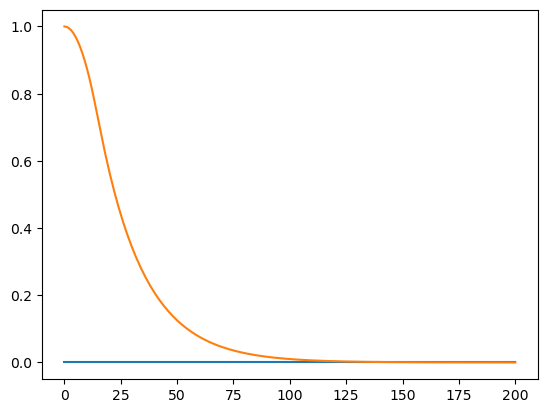

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c8a0efb0>

In [29]:
plot(xref[1,:])
plot(x[1,:])

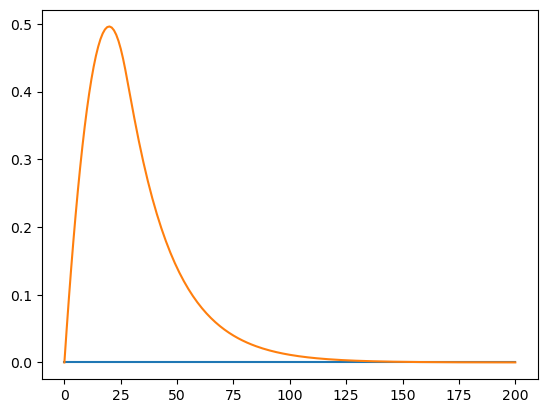

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c8a8fc70>

In [30]:
plot(xref[2,:])
plot(x[2,:])

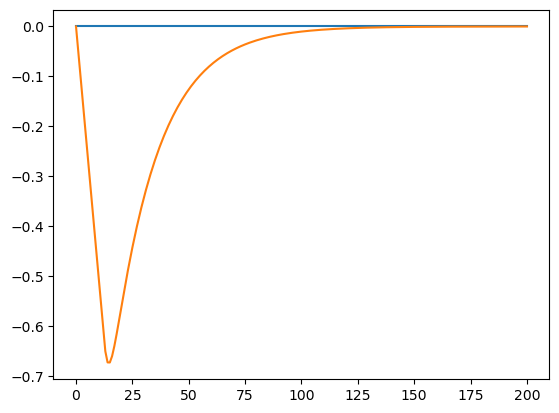

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c96d8910>

In [31]:
plot(xref[3,:])
plot(x[3,:])

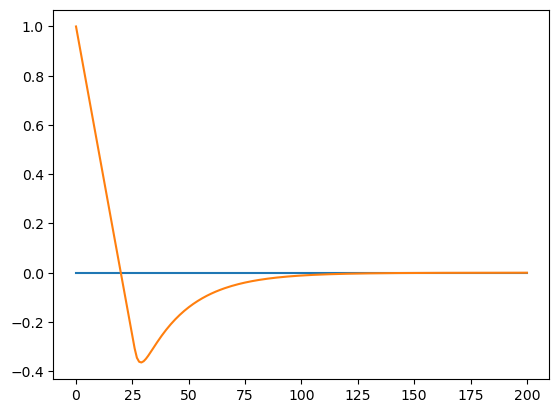

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c973e170>

In [32]:
plot(xref[4,:])
plot(x[4,:])

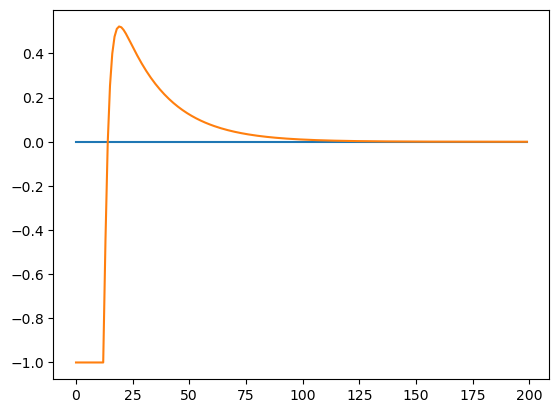

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c97ab9a0>

In [33]:
plot(uref[1,:])
plot(u[1,:])

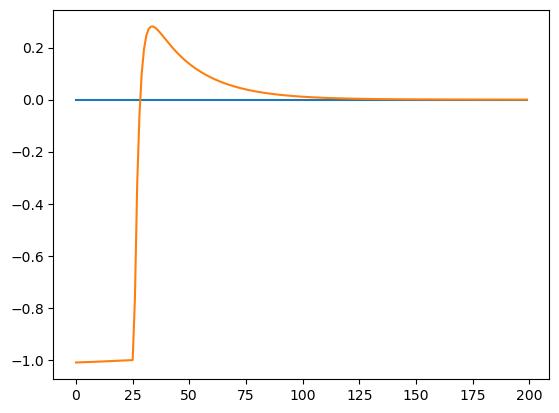

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c9835240>

In [34]:
plot(uref[2,:])
plot(u[2,:])

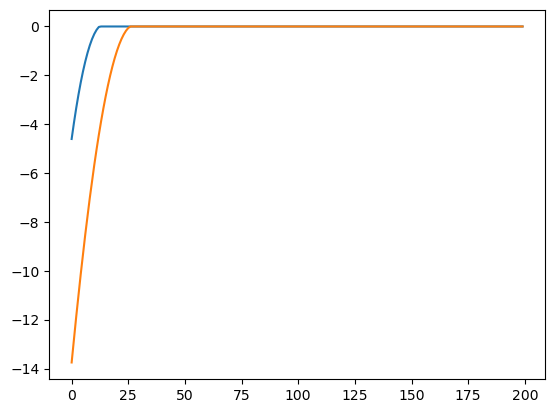

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c989e470>

In [35]:
plot(y[1,:])
plot(y[2,:])

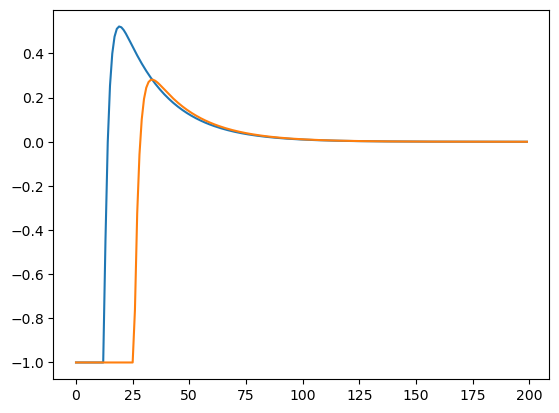

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1c98ffca0>

In [36]:
plot(w[1,:])
plot(w[2,:])